Note my python version:

In [1]:
import sys
print(sys.version)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


Packages you'll need:

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.ndimage import rotate

%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

# Scatter plot example

A function to sample from a bivariate normal distribution with a given rho and sample size n, and map the numbers to the [0, 59] range, so we can later put them in a plot matrix:

In [36]:
def sampleBVN(rho, n=50):
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    bvn = np.random.multivariate_normal(mean, cov, n)
    bvn = (np.round(bvn, 1) * 10 + 30).astype(int)
    bvn[bvn < 0] = 0
    bvn[bvn > 59] = 59
    r, p_val = st.pearsonr(bvn[:, 0], bvn[:, 1])
    sig = p_val < 0.05
    return bvn, r, sig

Sampling 1K samples for significant rhos (0.2 to 0.9, -0.9 to -0.2), keeping results in a pandas DataFrame:

In [91]:
N = 1000
sig_rhos = pd.DataFrame({'rho': np.repeat(np.concatenate((np.linspace(-9, -2, num=8), np.linspace(2, 9, num=8)))/10, N)})
apply_sampleBVN_to_rho = list(zip(*sig_rhos['rho'].apply(sampleBVN)))
sig_rhos['bvn'] = list(apply_sampleBVN_to_rho[0])
sig_rhos['r'] = apply_sampleBVN_to_rho[1]
sig_rhos['sig'] = apply_sampleBVN_to_rho[2]
print(sig_rhos.shape)
sig_rhos.head()

(16000, 4)


,rho,bvn,r,sig
0,-0.9,"[[35, 31], [41, 18], [35, 28], [40, 20], [6, 5...",-0.917696,True
1,-0.9,"[[25, 32], [15, 42], [31, 29], [36, 22], [30, ...",-0.871478,True
2,-0.9,"[[47, 6], [20, 38], [41, 19], [45, 23], [23, 4...",-0.904759,True
3,-0.9,"[[25, 31], [33, 25], [14, 34], [22, 31], [20, ...",-0.885019,True
4,-0.9,"[[36, 32], [34, 23], [38, 22], [30, 37], [30, ...",-0.933455,True


Sampling 3K samples for non-significant rhos (-0.1 to 0.1), keeping results in a pandas DataFrame:

In [92]:
N = 3000
non_sig_rhos = pd.DataFrame({'rho': np.repeat(np.linspace(-1, 1, num=3)/10, N)})
apply_sampleBVN_to_rho = list(zip(*non_sig_rhos['rho'].apply(sampleBVN)))
non_sig_rhos['bvn'] = list(apply_sampleBVN_to_rho[0])
non_sig_rhos['r'] = apply_sampleBVN_to_rho[1]
non_sig_rhos['sig'] = apply_sampleBVN_to_rho[2]
print(non_sig_rhos.shape)
non_sig_rhos.head()

(9000, 4)


,rho,bvn,r,sig
0,-0.1,"[[29, 35], [32, 42], [23, 35], [36, 49], [29, ...",-0.128261,False
1,-0.1,"[[31, 52], [26, 32], [38, 18], [16, 21], [48, ...",-0.325618,True
2,-0.1,"[[37, 36], [29, 18], [23, 31], [12, 35], [23, ...",-0.094985,False
3,-0.1,"[[49, 30], [35, 37], [27, 32], [33, 22], [13, ...",0.161271,False
4,-0.1,"[[37, 8], [34, 30], [28, 37], [39, 39], [33, 3...",-0.100069,False


In [93]:
non_sig_rhos.at[0, 'bvn'].shape

(50, 2)

See how many significant and insignificant p_vals out there:

In [39]:
pd.concat([sig_rhos, non_sig_rhos]).groupby('sig').count()

,rho,bvn,r
sig,,,
False,10953,10953,10953
True,14047,14047,14047


Sample 10K from each group and form raw data:

In [107]:
data_raw = pd.concat([sig_rhos, non_sig_rhos]).groupby('sig').apply(pd.DataFrame.sample, n=10000).reset_index(drop=True)
print(data_raw.shape)
data_raw.groupby('sig').count()

(20000, 4)


,rho,bvn,r
sig,,,
False,10000,10000,10000
True,10000,10000,10000


Define a matrix receiving a `bvn` array and turning it into a plot matrix with zeros everywhere and ones where there is a marker. The matrix is in fact a 4D array which is more suitable for deep learning later on:

In [47]:
def plot_mat(bvn):
    m = np.zeros((60, 60))
    m[bvn[:, 0], bvn[:, 1]] = 1
    return m.reshape((1, 60, 60, 1))

See that the matrix when reshaped to 2D is equivalent to a scatter plot of the bivariate normal sample:

In [109]:
res = plot_mat(data_raw.at[0, 'bvn'])
res.shape

(1, 60, 60, 1)

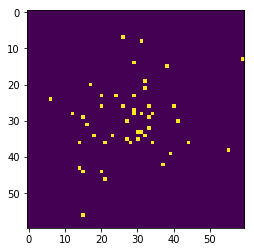

In [110]:
mat2d = rotate(res[0, :, :, 0], 90)
plt.imshow(mat2d, origin='upper')
plt.show()

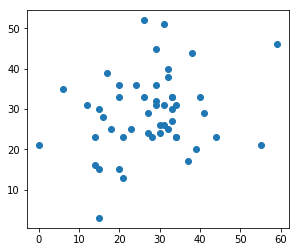

In [112]:
plt.axes().set_aspect('equal')
plt.scatter(data_raw.at[0, 'bvn'][:, 0], data_raw.at[0, 'bvn'][:, 1])
plt.show()

Unite 10K x 2 samples into a giant 20K x 60 x 60 x 1 (color channel) x matrix:

In [148]:
x = np.concatenate(data_raw['bvn'].apply(plot_mat))
x.shape

(20000, 60, 60, 1)

Split to train and test:

In [149]:
train_samp = np.random.choice(x.shape[0], 10000, replace=False)
x_train = x[train_samp, :, :, :]
x_test = x[-train_samp, :, :, :]
print(x_train.shape)
print(x_test.shape)

(10000, 60, 60, 1)
(10000, 60, 60, 1)


Create binary (0: significat, 1: insignificant) y variable:

In [150]:
y_classification = np.repeat([0, 1], 10000)

y_train_cl = y_classification[train_samp]
y_test_cl = y_classification[-train_samp]

Now, for Deep Learning with Keras:

In [155]:
batch_size = 128
epochs = 20
input_shape = (60, 60, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train_cl,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test_cl),
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)])

W0730 06:13:09.908955 140359276693312 deprecation.py:323] From /home/gioras/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 85s 9ms/step - loss: 0.4948 - acc: 0.7441 - val_loss: 0.5194 - val_acc: 0.7821
Epoch 2/20
10000/10000 [==============================] - 90s 9ms/step - loss: 0.2896 - acc: 0.8836 - val_loss: 0.1886 - val_acc: 0.9306
Epoch 3/20
10000/10000 [==============================] - 95s 10ms/step - loss: 0.2231 - acc: 0.9137 - val_loss: 0.3533 - val_acc: 0.8476
Epoch 4/20
10000/10000 [==============================] - 95s 9ms/step - loss: 0.1977 - acc: 0.9232 - val_loss: 0.1372 - val_acc: 0.9444
Epoch 5/20
10000/10000 [==============================] - 94s 9ms/step - loss: 0.1717 - acc: 0.9371 - val_loss: 0.2042 - val_acc: 0.9206
Epoch 6/20
10000/10000 [==============================] - 95s 9ms/step - loss: 0.1537 - acc: 0.9440 - val_loss: 0.1381 - val_acc: 0.9462
Test loss: -9.578178577804566
Test accuracy: 0.1026


In [156]:
score = model.evaluate(x_test, y_test_cl, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13805500635802745
Test accuracy: 0.9462
